# Laboratorio: CNN en Cats vs Dogs (Mini Dataset)

**Objetivo:** disenar y analizar una arquitectura convolucional (CNN), compararla con un baseline sin convoluciones y realizar un experimento controlado sobre una decision de la capa convolucional.

**Dataset:** Cats and Dogs Mini Dataset (Kaggle).

**Carpeta local:** `archive/cats_set` y `archive/dogs_set`


## 0. Setup

Usamos TensorFlow/Keras para construir los modelos y `tf.data` para el pipeline de datos.

In [1]:
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = Path("archive")
CAT_DIR = DATA_DIR / "cats_set"
DOG_DIR = DATA_DIR / "dogs_set"

IMG_SIZE = 64  # tamano fijo para todos los modelos
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

## 1. EDA (Exploracion de Datos)

Buscamos conocer tamano del dataset, clases, dimensiones de imagenes y ver ejemplos.

In [2]:
cat_files = sorted([p for p in CAT_DIR.glob('*.jpg')])
dog_files = sorted([p for p in DOG_DIR.glob('*.jpg')])

print('Cats:', len(cat_files))
print('Dogs:', len(dog_files))
print('Total:', len(cat_files) + len(dog_files))

Cats: 500
Dogs: 500
Total: 1000


In [3]:
# Ver dimensiones de algunas imagenes
sample_paths = cat_files[:3] + dog_files[:3]
for p in sample_paths:
    with Image.open(p) as img:
        print(p.name, img.size, img.mode)

cat.4001.jpg (498, 415) RGB
cat.4002.jpg (375, 499) RGB
cat.4003.jpg (500, 399) RGB
dog.4001.jpg (421, 499) RGB
dog.4002.jpg (428, 500) RGB
dog.4003.jpg (297, 447) RGB


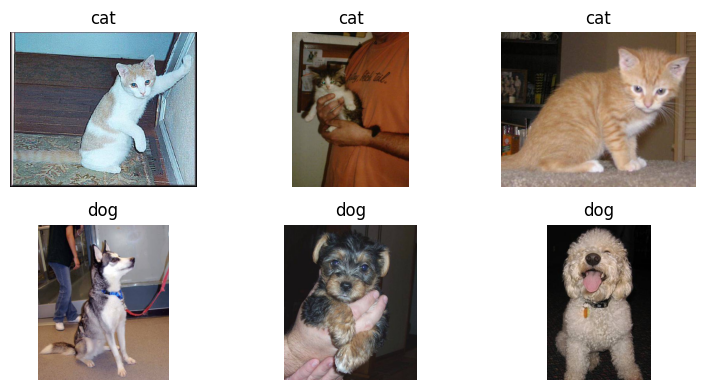

In [4]:
# Visualizar ejemplos
plt.figure(figsize=(8, 4))
for i, p in enumerate(cat_files[:3] + dog_files[:3]):
    img = Image.open(p)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title('cat' if 'cat.' in p.name else 'dog')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Preprocesamiento propuesto
- Redimensionar todas las imagenes a `IMG_SIZE x IMG_SIZE`
- Normalizar pixeles a rango [0, 1]
- Dividir en train/val/test (80/10/10)

In [5]:
# Crear dataset con labels
filepaths = np.array([str(p) for p in cat_files + dog_files])
labels = np.array([0] * len(cat_files) + [1] * len(dog_files))

# Shuffle y split
rng = np.random.default_rng(SEED)
indices = rng.permutation(len(filepaths))
filepaths = filepaths[indices]
labels = labels[indices]

n_total = len(filepaths)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

train_paths, train_labels = filepaths[:n_train], labels[:n_train]
val_paths, val_labels = filepaths[n_train:n_train + n_val], labels[n_train:n_train + n_val]
test_paths, test_labels = filepaths[n_train + n_val:], labels[n_train + n_val:]

print('Train:', len(train_paths))
print('Val:', len(val_paths))
print('Test:', len(test_paths))

Train: 800
Val: 100
Test: 100


In [6]:
def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(paths, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels, shuffle=True)
val_ds = make_dataset(val_paths, val_labels, shuffle=False)
test_ds = make_dataset(test_paths, test_labels, shuffle=False)

## 2. Baseline (Sin Convoluciones)

Modelo base: **Flatten + Dense**. Esto ignora la estructura espacial y sirve como referencia.

Limitaciones esperadas: muchos parametros y perdida de informacion espacial.

In [7]:
baseline = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

baseline.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,250 (6.00 MB)

 Trainable params: 1,573,250 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history_baseline = baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.4679 - loss: 4.6964 - val_accuracy: 0.4800 - val_loss: 0.7119
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4867 - loss: 0.7366 - val_accuracy: 0.5900 - val_loss: 0.6719
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6001 - loss: 0.6679 - val_accuracy: 0.5000 - val_loss: 0.7173
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6131 - loss: 0.6701 - val_accuracy: 0.5700 - val_loss: 0.7414
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5609 - loss: 0.6983 - val_accuracy: 0.5100 - val_loss: 0.7056
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6859 - loss: 0.6313 - val_accuracy: 0.5600 - val_loss: 0.6903
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6539 - loss: 0.6322 - val_accuracy: 0.5500 - val_loss: 0.6844
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6501 - loss: 0.6144 - val_accuracy: 0.5500 - v

In [9]:
baseline_eval = baseline.evaluate(test_ds)
print('Baseline test:', baseline_eval)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6251 - loss: 0.6853 
Baseline test: [0.6948021054267883, 0.6200000047683716]


## 3. Diseno de CNN

CNN simple con 3 bloques convolucionales. Las decisiones se justifican: kernels pequenos (3x3) capturan patrones locales, pooling reduce dimensionalidad y aporta invariancia, y activaciones ReLU ayudan a la no linealidad.

In [10]:
def build_cnn(kernel_size=3):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, kernel_size=kernel_size, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

cnn = build_cnn(kernel_size=3)
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,210 (4.36 MB)

 Trainable params: 1,142,210 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history_cnn = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.4768 - loss: 0.7625 - val_accuracy: 0.5700 - val_loss: 0.6895
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5622 - loss: 0.6914 - val_accuracy: 0.6900 - val_loss: 0.6831
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.5792 - loss: 0.6753 - val_accuracy: 0.6500 - val_loss: 0.6555
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6604 - loss: 0.6150 - val_accuracy: 0.6400 - val_loss: 0.6644
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.6887 - loss: 0.5968 - val_accuracy: 0.7100 - val_loss: 0.6196
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7134 - loss: 0.5548 - val_accuracy: 0.6700 - val_loss: 0.5832
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7457 - loss: 0.5264 - val_accuracy: 0.7100 - val_loss: 0.6280
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.7876 - loss: 0.4802 - val_accuracy: 0.6900 -

In [12]:
cnn_eval = cnn.evaluate(test_ds)
print('CNN test:', cnn_eval)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6892 - loss: 0.6286
CNN test: [0.5799809694290161, 0.7099999785423279]


## 4. Experimento Controlado (Kernel Size)

Comparamos kernel 3x3 vs 5x5 manteniendo todo lo demas fijo.

In [13]:
cnn_3 = build_cnn(kernel_size=3)
cnn_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_5 = build_cnn(kernel_size=5)
cnn_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn_3 = cnn_3.fit(train_ds, validation_data=val_ds, epochs=10)
history_cnn_5 = cnn_5.fit(train_ds, validation_data=val_ds, epochs=10)

eval_3 = cnn_3.evaluate(test_ds)
eval_5 = cnn_5.evaluate(test_ds)

print('CNN 3x3 test:', eval_3)
print('CNN 5x5 test:', eval_5)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5033 - loss: 0.7332 - val_accuracy: 0.6500 - val_loss: 0.6905
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5650 - loss: 0.6901 - val_accuracy: 0.4300 - val_loss: 0.7077
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.5506 - loss: 0.6849 - val_accuracy: 0.6500 - val_loss: 0.6336
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6616 - loss: 0.6186 - val_accuracy: 0.5700 - val_loss: 0.6780
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6357 - loss: 0.6492 - val_accuracy: 0.6300 - val_loss: 0.6433
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.7308 - loss: 0.5765 - val_accuracy: 0.6700 - val_loss: 0.6290
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7710 - loss: 0.5075 - val_accuracy: 0.6400 - val_loss: 0.6064
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7940 - loss: 0.4865 - val_accuracy: 0.

### Observaciones cualitativas
- Kernel 3x3 suele capturar patrones locales finos y permite composicion de features.
- Kernel 5x5 puede capturar contexto mas amplio, pero aumenta parametros y puede sobreajustar en datasets pequenos.

## 5. Interpretacion y Razonamiento Arquitectonico

Responde en tus propias palabras:
- Por que la CNN supera (o no) al baseline?

    La CNN suele superar al baseline porque explota la estructura espacial de las imágenes: aprende filtros locales que se reutilizan por toda la imagen (compartición de pesos) y construye jerarquías de patrones (bordes → texturas → partes). El baseline con Flatten + Dense pierde esa estructura y necesita muchos más parámetros para lograr algo similar, lo que lo hace menos eficiente y más propenso al sobreajuste en datasets pequeños.
    
- Que sesgo inductivo introduce la convolucion?

    La convolución introduce el sesgo inductivo de localidad y equivarianza a traslaciones: asume que patrones pequeños relevantes pueden aparecer en cualquier ubicación y que la misma operación (filtro) sirve en toda la imagen. Además, con pooling se introduce cierta invariancia a pequeñas traslaciones y distorsiones.

- En que problemas no es apropiado usar convoluciones?

    No es apropiado usar convoluciones cuando no hay estructura espacial local o cuando la posición exacta no es relevante para la tarea. Ejemplos: datos tabulares con features independientes, series de tiempo donde la relación no es local en el eje, grafos donde la conectividad no es una grilla regular, o problemas donde la información global (no local) domina y la localidad no es una buena suposición.

## 6. SageMaker (Entrenamiento y Deployment)

En esta seccion entrenamos el modelo en SageMaker y lo desplegamos. Requiere un rol IAM y un bucket S3. Ajusta los valores segun tu cuenta.

ModuleNotFoundError: No module named 'sagemaker'